# IMPORT and standard tweaking

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
#visualization option

In [2]:
# display all columns
pd.set_option('display.max_columns', None)

In [3]:
viral=pd.read_csv(r'data/analysis/viral_charts_songs_2017-2020.csv')

In [4]:
viral.head()

,Position,Track Name,Artist,URL,filename,ID,date,country,group,length,popularity,acousticness,danceability,energy,key,instrumentalness,liveness,loudness,mode,speechiness,valence,tempo,loud_start
0,1,Sucker,Jonas Brothers,https://open.spotify.com/track/4y3OI86AEP6PQoD...,2019-03-27-in-viral.csv,4y3OI86AEP6PQoDE6olYhO,2019-03-27,in,viral,181040,9,0.0427,0.842,0.734,1,0.000000,0.1060,-5.065,0,0.0588,0.952,137.958,-11.142
1,2,Undrunk,FLETCHER,https://open.spotify.com/track/5SHhPFh68OhUmuR...,2019-03-27-in-viral.csv,5SHhPFh68OhUmuRPymKX9d,2019-03-27,in,viral,183428,0,0.4550,0.679,0.572,5,0.000002,0.1270,-6.703,1,0.0781,0.542,92.859,-8.190
2,3,Don't Call Me Up,Mabel,https://open.spotify.com/track/5WHTFyqSii0lmT9...,2019-03-27-in-viral.csv,5WHTFyqSii0lmT9R21abT8,2019-03-27,in,viral,178480,79,0.2960,0.674,0.881,9,0.000003,0.0793,-2.853,1,0.1470,0.234,98.994,-5.559
3,4,Moonlight,Gaullin,https://open.spotify.com/track/0A5gdlrpAuQqZ2i...,2019-03-27-in-viral.csv,0A5gdlrpAuQqZ2iFgnqBFW,2019-03-27,in,viral,173066,72,0.0529,0.813,0.761,10,0.011900,0.3370,-5.687,0,0.0850,0.290,124.957,-5.704
4,5,i'm so tired...,Lauv,https://open.spotify.com/track/7COXchtUOMd6uIT...,2019-03-27-in-viral.csv,7COXchtUOMd6uIT6HvmRaI,2019-03-27,in,viral,162582,13,0.1760,0.599,0.733,11,0.000000,0.2420,-7.058,1,0.2030,0.534,102.211,-12.880


In [5]:
viral.columns

Index(['Position', 'Track Name', 'Artist', 'URL', 'filename', 'ID', 'date',
       'country', 'group', 'length', 'popularity', 'acousticness',
       'danceability', 'energy', 'key', 'instrumentalness', 'liveness',
       'loudness', 'mode', 'speechiness', 'valence', 'tempo', 'loud_start'],
      dtype='object')

remarks on the features
* 'valence' indicates the 'happiness' the lower the score the sader the music. [refercence](https://community.spotify.com/t5/Content-Questions/Valence-as-a-measure-of-happiness/td-p/4385221)
* mode 0/1 indicates major/minor (dur/moll)

In [6]:
#rename column length to duration to match the kaggle dataframe
viral=viral.rename(columns={'length':'duration_ms'})


#### dtypes tweaking

In [7]:
viral.dtypes

Position              int64
Track Name           object
Artist               object
URL                  object
filename             object
ID                   object
date                 object
country              object
group                object
duration_ms           int64
popularity            int64
acousticness        float64
danceability        float64
energy              float64
key                   int64
instrumentalness    float64
liveness            float64
loudness            float64
mode                  int64
speechiness         float64
valence             float64
tempo               float64
loud_start          float64
dtype: object

In [8]:
#date to datetime
viral.date=pd.to_datetime(viral.date, format="%Y-%m-%d", yearfirst=True)

# mode and key are categroical values
viral['mode'] = viral['mode'].apply(str)
viral['key'] = viral['key'].apply(str)

In [9]:
viral['key']

0         1
1         5
2         9
3        10
4        11
         ..
13272     8
13273    11
13274     6
13275     9
13276     6
Name: key, Length: 13277, dtype: object

In [10]:
# mapping country codes to real country names
keys=list(sorted(set(viral.country)))
values=['Argentina','Australia','Brazil','Canada','Germany','Egypt','Spain','United Kingdom','Indonesia','India','Iceland','Italy','Japan','Marocco','Mexico','New Zealand','Russia','Turkey','Ukraine','South Africa']
country_dict = dict(zip(keys, values))
viral['country']=viral['country'].map(country_dict) 

# CAN WE PREDICT IF SONGS ARE VIRAL SONGS
* Supervised learning model with K NEAREST NEIGHBORS
* Will the musical features of snongs labeled as viral be distinguishable enough?
* Using a large kaggle song data base as baseline to compare against songs from viral charts
* https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks

In [11]:
kaggle=pd.read_csv(r'data/kaggle/data.csv')

In [12]:
#adding column indicating they are not the viral songs
kaggle['group']='random'

In [13]:
# mode and key are categroical values
kaggle['mode'] = kaggle['mode'].apply(str)
kaggle['key'] = kaggle['key'].apply(str)

In [14]:
# only want to keep songs from 2015 to 2020 to avoid accidentally measuring change in music production
base=kaggle[kaggle['year'].isin([2015,2016,2017,2018,2019,2020])]
print('# of records: ',len(base))
#sadly reissues of old songs cannot be filterd out (ex. Frank Sinatra and Joni Mitchel)

# of records:  16142


# K NEAREST NEIGHBOUR
* check multicollinearity
* check outliers
* create dummies for categorical variable (ex key & mode)
* distance based algorithms demand that all variables need to be standardized
* they all need to be on the same scale 


In [15]:
from sklearn.neighbors import KNeighborsClassifier

### create joint dataframe 
create joint df of viral charts songs and songs from kaggle DB I want to compare against

In [16]:
# list of relevant columns
knear_features=["group",
            "acousticness",
            "danceability",
            "duration_ms",
            "energy",
            "instrumentalness",
            "liveness",
            "loudness",
            "speechiness",
            "tempo",
            "valence",
            "key",
            "mode"]

In [17]:
#concat viral df with data from kaggle i use as base
knear_df=pd.concat([viral[knear_features],base[knear_features]],axis=0,ignore_index=True)

In [18]:
#rename target variable and make it numerical: viral 1 or 0
knear_df=knear_df.rename(columns={'group':'viral'})
knear_df.viral=np.where(knear_df.viral=='viral',1,0)

In [19]:
knear_df.viral.value_counts()

0    16142
1    13277
Name: viral, dtype: int64

### checking multicollinearity

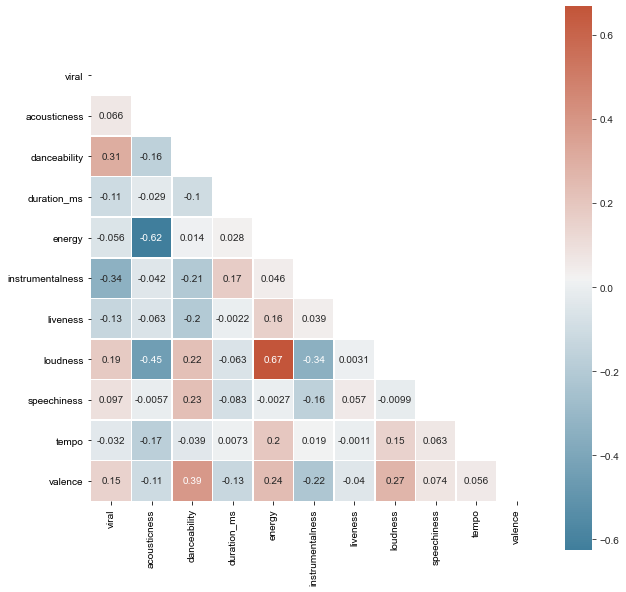

In [20]:
#
corr = knear_df.corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.set_style("darkgrid")
mask = np.triu(np.ones_like(corr, dtype=bool)) # removing the other side of the heatmap
cmap = sns.diverging_palette(230, 20, as_cmap=True) #preparing cmap
sns.heatmap(corr,mask=mask,cmap=cmap,linewidths=.5,square=True,annot=True)
plt.show()

* interesting: viral pos correspondes w/ danceability, loudness
* interesting: viral neg correspondes w/instrumentalness 
* energy and loudness have strong correlation.
* I keep energy and loudness since their impact on the target seems to be quite different

In [21]:
## THOMAS HIER MUSST DU NOCH WAS MACHEN!
## ALS NÄCHSTES AUS MODE UND KEY DUMMIES MACHEN
## IST MODE 1 dur oder moll

### creat model k nearest neighbour
sklearn

In [22]:
from sklearn.model_selection import train_test_split
y=knear_df['viral']
X=knear_df.drop('viral',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)

In [23]:
from sklearn.neighbors import KNeighborsClassifier

knear_model = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
predictions = knear_model.predict(X_test)
print(knear_model.score(X_test, y_test))
print(pd.Series(predictions).value_counts())

0.7111658735554045
0    6188
1    5580
dtype: int64


In [24]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, predictions)
print(cf_matrix)


[[4612 1823]
 [1576 3757]]


Text(0.5, 1.0, 'CONFUSION MATRIX')

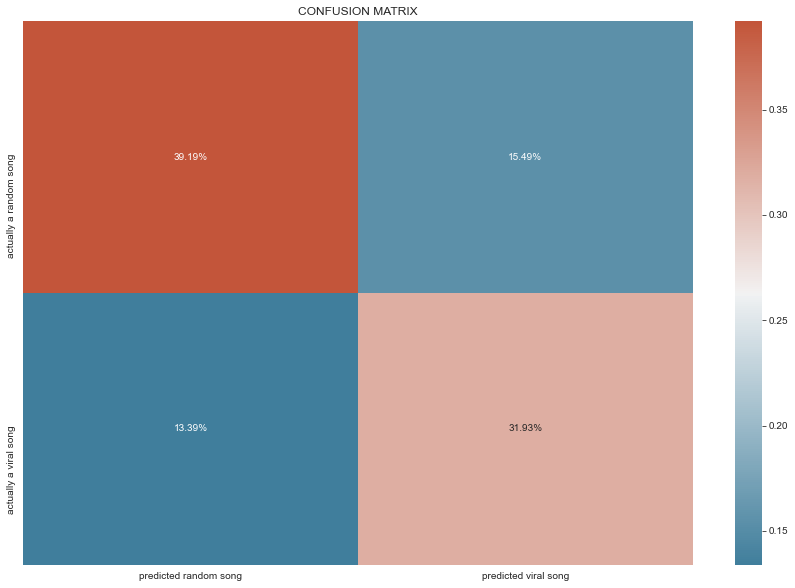

In [25]:
plt.figure(figsize=(15,10))
cmap = sns.diverging_palette(230, 20, as_cmap=True) #preparing cmap

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap=cmap,xticklabels=[ 'predicted random song', 'predicted viral song'],
            yticklabels=['actually a random song','actually a viral song']).set_title('CONFUSION MATRIX')


In [26]:
# to do???
# hyper model tweaking
# most important features
# how are the 2 most important features distributed around the globe for viral songs in there respective viral charts

# NOTES

PLOTS
https://seaborn.pydata.org/tutorial/distributions.html